# Backtesting MPT

# Objective:
- Construct Efficient Portfolio using past 1 year's data
- Hold for the next six months.
- Compare returns with the index.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
tickers = ['ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BHARTIARTL.NS', 'BPCL.NS', 'BRITANNIA.NS', 'CIPLA.NS', 'COALINDIA.NS', 'DIVISLAB.NS', 'DRREDDY.NS', 'EICHERMOT.NS', 'GRASIM.NS', 'HCLTECH.NS', 'HDFC.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS', 'HEROMOTOCO.NS', 'HINDALCO.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'INDUSINDBK.NS', 'INFY.NS', 'ITC.NS', 'JSWSTEEL.NS', 'KOTAKBANK.NS', 'LT.NS', 'M&M.NS', 'MARUTI.NS', 'NESTLEIND.NS', 'NTPC.NS', 'ONGC.NS', 'POWERGRID.NS', 'RELIANCE.NS', 'SBIN.NS', 'SBILIFE.NS', 'SHREECEM.NS', 'SUNPHARMA.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'TCS.NS', 'TATACONSUM.NS', 'TECHM.NS', 'TITAN.NS', 'ULTRACEMCO.NS', 'UPL.NS', 'WIPRO.NS']

In [3]:
# RISK FREE RATE ASSUMED TO BE 5% 
rf = 0.05
n = len(tickers)

### Equity and Index Data

In [4]:
close_data = pd.DataFrame(yf.download(tickers, start = dt.date(2017,12,29), end = dt.date(2022,7,1))['Close'])
nifty_close_data = pd.DataFrame(yf.download("^NSEI", start = dt.date(2017,12,29), end = dt.date(2022,7,1))['Close'])
return_data = close_data.pct_change()
nifty_return_data = nifty_close_data.pct_change()
return_data = return_data.iloc[1:, :]
nifty_return_data = nifty_return_data.iloc[1:, :]

[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
dropthese = []
for i in return_data.index:
    if i not in nifty_return_data.index:
        dropthese.append(i)
        
return_data.drop(dropthese, inplace = True)

### Functions

In [6]:
# Random Weights
def random_weights(n):
    # n is number of components
    w = np.random.random((n,1))
    w /= np.sum(w)
    return w

# Checking Sum of Weights to be One
def checkSumToOne(w):
    return np.sum(w)-1

# Portfolio Return
# Define returns array before calling this function
def exp_pret(w):
    pret = w.T @ ret
    pret = pret.sum()
    return pret

# Portfolio Risk
# Define covariance matrix before calling this function
def exp_prisk(w):
    prisk = np.sqrt(((w.T @ var) @ w).sum())
    return prisk

# Calculating Negative Sharpe Ratio
# Define returns array before calling this function
# Define covariance matrix before calling this function
def negSharpe(w):
    return -1*((exp_pret(w)-rf)/exp_prisk(w))

## Time Periods
- Train is the time period of historical data using which the portfolio is constructed.
- Test is the holding period used to calculate returns.
- Period is the time period after which the portfolio is rebalanced.

In [7]:
train = 252
test = 126
period = 21

## Backtesting Loop

In [8]:
results = []
start = 0
end = start + train
test_start = end
test_end = test_start + test

while test_end <= nifty_return_data.shape[0]:
    ####################################################################################################
    # Dates
    end = start + train
    test_start = end
    test_end = test_start + test
    ####################################################################################################
    # Datasets
    returndata = return_data.iloc[start:end, :]
    test_returndata = return_data.iloc[test_start:test_end, :]
    test_nifty_returndata = nifty_return_data.iloc[test_start:test_end, :]
    ####################################################################################################
    # Annualized Returns
    annrets = pd.DataFrame(index = [0])
    for i in tickers:
        k = returndata.loc[:,i].mean()
        annrets[i] = (1+k)**train - 1
    # annrets
    ####################################################################################################
    # Annualized Variance-Covariance Matrix
    annvar = returndata.cov() * train
    # annvar
    ####################################################################################################
    # Returns and Variance-Covariance Matrix as nparrays
    ret = annrets.to_numpy().reshape((n,1))
    var = annvar.to_numpy()
    ####################################################################################################
    # # Minimizing Negative Sharpe Ratio (Setup)

    # Random Weights
    w0 = random_weights(n)

    # Weights' Bounds
    bounds = []
    for i in tickers:
        bounds.append((0,1))
    bounds = tuple(bounds)

    # Problem Constraints
    constraints = ({'type':'eq', 'fun':checkSumToOne})
    ####################################################################################################
    # Max Sharpe Ratio Weights
    maxsharpeweights = minimize(negSharpe,w0,method = 'SLSQP', bounds = bounds, constraints = constraints).x.round(4).reshape((50,1))
    ####################################################################################################
    # Min Variance Weights
    minvarweights = minimize(exp_prisk,w0,method = 'SLSQP', bounds = bounds, constraints = constraints).x.round(4).reshape((50,1))
    ####################################################################################################
    # Testing Performance
    ms_port_value = (test_returndata.to_numpy()@maxsharpeweights+1).cumprod()[-1]
    mv_port_value = (test_returndata.to_numpy()@minvarweights+1).cumprod()[-1]
    nifty_value = (test_nifty_returndata.to_numpy()+1).cumprod()[-1]
    ####################################################################################################
    results.append({'Start Date': returndata.index[0],
                    'End Date': returndata.index[-1],
                    'Test Start Date': test_returndata.index[0],
                    'Test End Date': test_returndata.index[-1],
                    'MS Value': ms_port_value,
                    'MV Value': mv_port_value,
                    'Index Value': nifty_value,
                    'MS Difference': ms_port_value - nifty_value,
                    'MV Difference': mv_port_value - nifty_value})
    
    # print(ms_port_value, mv_port_value, nifty_value, ms_port_value - nifty_value, mv_port_value - nifty_value)
    ####################################################################################################
    # print(start)
    start += period

## Results DataFrame

In [9]:
results = pd.DataFrame(results)

### % of times when Max Sharpe Ratio Portfolio beat market returns.

In [10]:
round((np.where(results['MS Difference']>0,1,0).sum()/len(results['MS Difference']))*100, 2)

52.78

### % of times when Min Var Portfolio beat market returns.

In [11]:
round((np.where(results['MV Difference']>0,1,0).sum()/len(results['MV Difference']))*100, 2)

47.22

## Plots

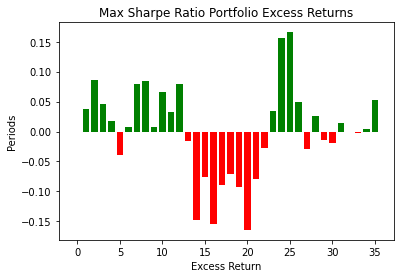

In [12]:
diff = np.where(results['MS Difference']>0, 'g','r')
plt.bar(x = results.index, height = results['MS Difference'], color = diff)
plt.xlabel("Excess Return")
plt.ylabel('Periods')
plt.title("Max Sharpe Ratio Portfolio Excess Returns")
plt.show()

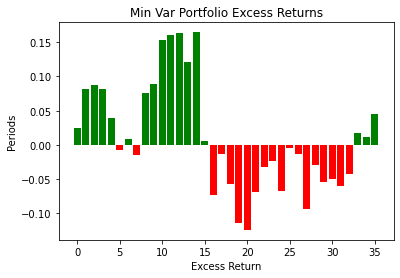

In [13]:
diff = np.where(results['MV Difference']>0, 'g','r')
plt.bar(x = results.index, height = results['MV Difference'], color = diff)
plt.xlabel("Excess Return")
plt.ylabel('Periods')
plt.title("Min Var Portfolio Excess Returns")
plt.show()

# Fin.